In [1]:
from PIL import Image
import os
import pandas as pd
import numpy as np
import datasets
from tqdm import tqdm
from datasets import Image as Image_ds # change name because of similar PIL module
from datasets import Dataset
from datasets import load_dataset
import urllib.parse
import json
import pickle
import requests
import matplotlib.pyplot as plt 
from sklearn.neighbors import NearestNeighbors
import re
import sys
sys.path.append(os.path.abspath(".."))
from src.utils import plot_neighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from matplotlib.patches import Patch
from random import sample

### Load data, add embeddings, filter for paintings only

In [49]:
# read df from pickle 
data_path = os.path.join('..', 'data')
df = pd.read_pickle(os.path.join(data_path, 'all_paintings_canonized.pkl'))

In [3]:
# load image data
ds = load_dataset("louisebrix/smk_all_paintings", split="train") # all the data is in the 'train' split

In [ ]:
exb_canon = []

for idx, row in df.iterrows():
    exb_years = row['ex_years']

    if isinstance(exb_years, list):
        match = False
        for year in exb_years:
            if year.startswith('2') == True:
                match = True
                break
            
            else:
                continue

        if match == True:
            exb_canon.append('canon')
        
        else:
            exb_canon.append('other')

    else:
        exb_canon.append('other')

df['exb_canon'] = exb_canon

In [51]:
df['exb_canon'].value_counts()

exb_canon
other    1046
canon     644
Name: count, dtype: int64

## Check exhibitions data

Text(0, 0.5, 'Count')

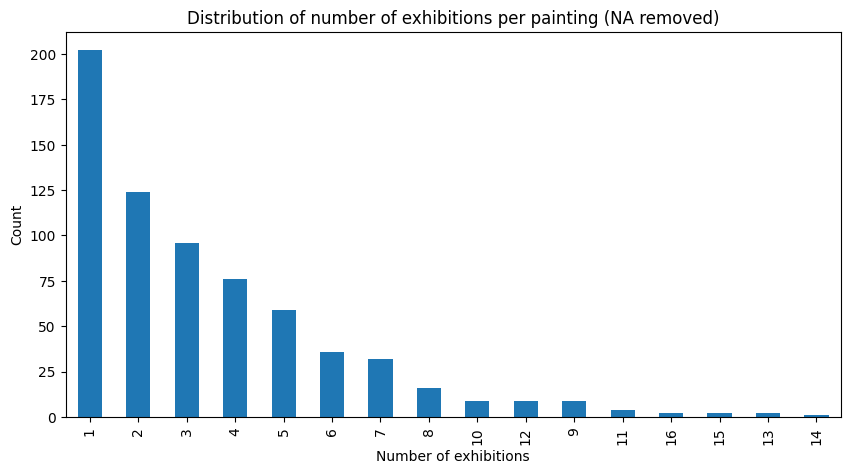

In [27]:
df['n_exhibitions'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.title('Distribution of number of exhibitions per painting (NA removed)')
plt.xlabel('Number of exhibitions')
plt.ylabel('Count')

In [28]:
def get_ex_dates(ex_dict_list):
    
    dates = []
    if isinstance(ex_dict_list, list):
        
        for e in ex_dict_list:
            start_date = e.get('date_start', None)

            if start_date:
                start_year = start_date.split('-')[0]
                dates.append(start_year)
            else:
                dates.append(pd.NA)
        
    else:
        dates = pd.NA
    
    return dates

In [29]:
ex_dates = [get_ex_dates(ex_dict_list) for ex_dict_list in df['exhibitions']]
df['ex_years'] = ex_dates

Text(0, 0.5, 'Count')

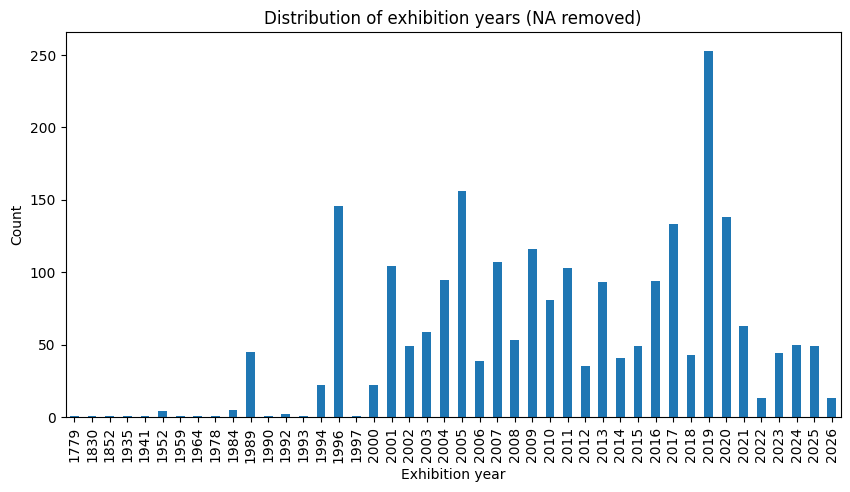

In [30]:
df['ex_years'].explode().value_counts().sort_index().plot(kind='bar', figsize=(10, 5))
plt.title('Distribution of exhibition years (NA removed)')
plt.xlabel('Exhibition year')
plt.ylabel('Count')

In [31]:
def get_ex_distances(row):

    prod_year = row['start_year']
    diffs = []

    if isinstance(row['ex_years'], list):
        for year in row['ex_years']:
            if isinstance(year, str):
                diff = int(year) - int(prod_year) 
                diffs.append(diff)
            else:
                diffs.append(pd.NA)
    else:
        diffs = pd.NA
    
    return diffs

In [32]:
ex_distances = [get_ex_distances(row) for idx, row in df.iterrows()]
df['ex_distances'] = ex_distances

In [33]:
df['ex_distances'].explode().dropna().astype(int).iloc[0]

np.int64(185)

Text(0, 0.5, 'Count')

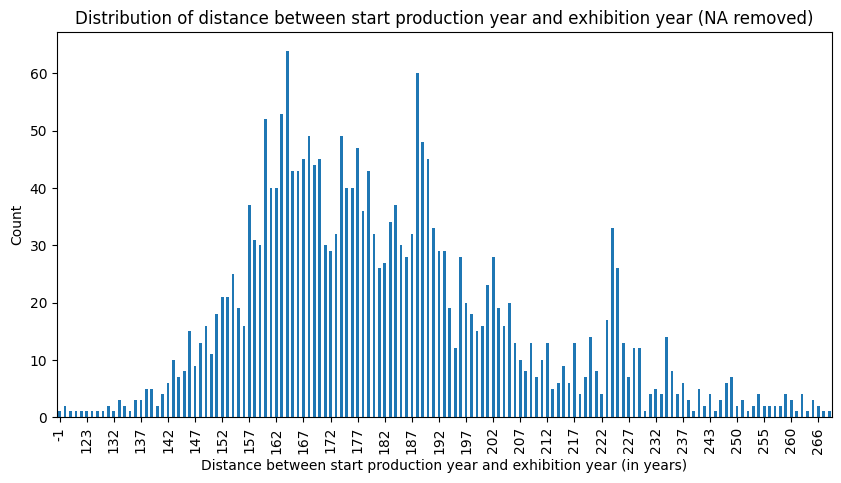

In [34]:
year_counts = df['ex_distances'].explode().value_counts().sort_index()
ax = year_counts.plot(kind='bar', figsize=(10, 5))

N = 5
ax.set_xticks(range(0, len(year_counts), N))
ax.set_xticklabels(year_counts.index[::5])
plt.title('Distribution of distance between start production year and exhibition year (NA removed)')
plt.xlabel('Distance between start production year and exhibition year (in years)')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

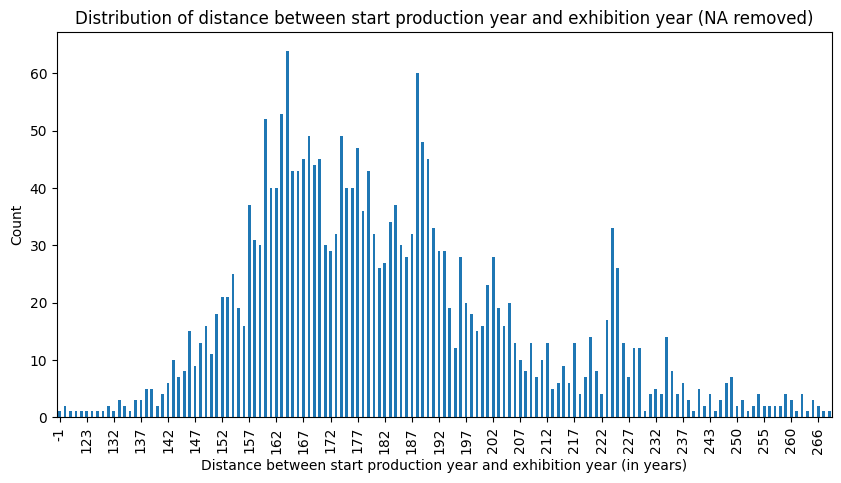

In [35]:
year_counts = df['ex_distances'].explode().value_counts().sort_index()
ax = year_counts.plot(kind='bar', figsize=(10, 5))

N = 5
ax.set_xticks(range(0, len(year_counts), N))
ax.set_xticklabels(year_counts.index[::5])
plt.title('Distribution of distance between start production year and exhibition year (NA removed)')
plt.xlabel('Distance between start production year and exhibition year (in years)')
plt.ylabel('Count')

In [36]:
exb_df = df.explode('ex_years').query('exb_canon == 1')
exb_df[exb_df['ex_years'].isnull()]

,smk_id,period,start_year,title,first_artist,all_artists,num_artists,main_type,all_types,image_thumbnail,...,canon,n_exhibitions,n_golden_titles,n_smk_exhibitions,embedding,grey_embedding,ex_years,ex_distances,smk_distances,dist_canon


In [37]:
def get_ex_distances_smk(row):

    if pd.notna(row['acquisition_date']):
        acq_year = row['acquisition_date'].split('-')[0]
        diffs = []

        if isinstance(row['ex_years'], list):
            for idx, year in enumerate(row['ex_years']):
                if isinstance(year, str) and isinstance(row['exhibition_venues'], list):
                    if pd.notna(row['exhibition_venues'][idx]) and row['exhibition_venues'][idx] == 'Sølvgade':
                        diff = int(year) - int(acq_year) 
                        diffs.append(diff)
                    else:
                        diffs.append(pd.NA)
                else:
                    diffs.append(pd.NA)
        else:
            diffs = pd.NA
    else:
        diffs = pd.NA
    return diffs

In [38]:
smk_distances = [get_ex_distances_smk(row) for idx, row in df.iterrows()]
df['smk_distances'] = smk_distances

Text(0, 0.5, 'Count')

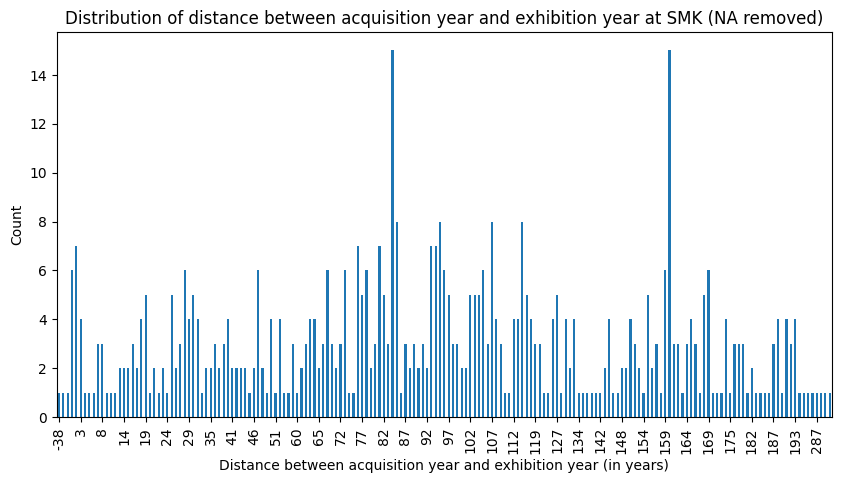

In [39]:
year_counts = df['smk_distances'].explode().value_counts().sort_index()
ax = year_counts.plot(kind='bar', figsize=(10, 5))

N = 5
ax.set_xticks(range(0, len(year_counts), N))
ax.set_xticklabels(year_counts.index[::5])
plt.title('Distribution of distance between acquisition year and exhibition year at SMK (NA removed)')
plt.xlabel('Distance between acquisition year and exhibition year (in years)')
plt.ylabel('Count')

In [40]:
dist_canon = []
for dists in df['ex_distances']:

    canon = 0
    if isinstance(dists, list):
        big_dists = [i for i in dists if i > 150]

        if len(big_dists) > 0:
            canon =+ 1
        else:
            canon =+ 0
        dist_canon.append(canon)
    else:
        dist_canon.append(0)

In [41]:
df['dist_canon'] = dist_canon

[Text(2, 0, '534'),
 Text(2, 0, '119'),
 Text(2, 0, '101'),
 Text(2, 0, '96'),
 Text(2, 0, '93'),
 Text(2, 0, '92'),
 Text(2, 0, '72'),
 Text(2, 0, '61'),
 Text(2, 0, '61'),
 Text(2, 0, '50'),
 Text(2, 0, '50'),
 Text(2, 0, '47'),
 Text(2, 0, '42'),
 Text(2, 0, '38'),
 Text(2, 0, '37'),
 Text(2, 0, '37'),
 Text(2, 0, '36'),
 Text(2, 0, '36'),
 Text(2, 0, '33'),
 Text(2, 0, '33'),
 Text(2, 0, '28'),
 Text(2, 0, '27'),
 Text(2, 0, '27'),
 Text(2, 0, '24'),
 Text(2, 0, '21'),
 Text(2, 0, '21'),
 Text(2, 0, '20'),
 Text(2, 0, '20'),
 Text(2, 0, '18'),
 Text(2, 0, '16'),
 Text(2, 0, '16'),
 Text(2, 0, '13'),
 Text(2, 0, '13'),
 Text(2, 0, '13'),
 Text(2, 0, '11'),
 Text(2, 0, '11'),
 Text(2, 0, '10'),
 Text(2, 0, '10'),
 Text(2, 0, '10'),
 Text(2, 0, '10'),
 Text(2, 0, '9'),
 Text(2, 0, '9'),
 Text(2, 0, '9'),
 Text(2, 0, '8'),
 Text(2, 0, '8'),
 Text(2, 0, '8'),
 Text(2, 0, '8'),
 Text(2, 0, '8'),
 Text(2, 0, '7'),
 Text(2, 0, '7')]

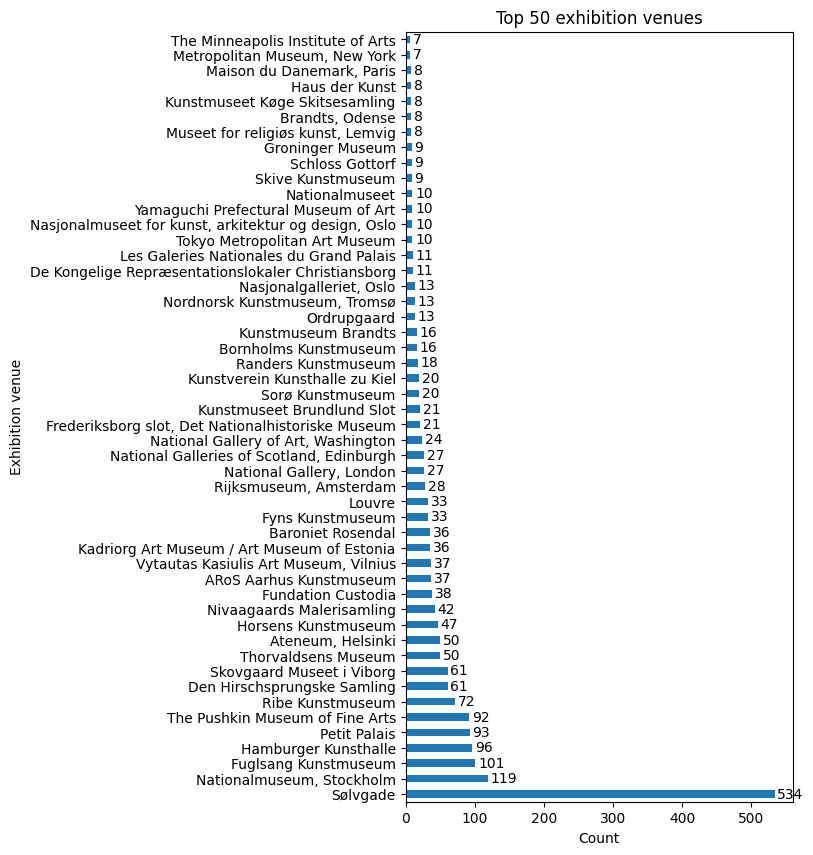

In [42]:
ax = df['exhibition_venues'].explode().value_counts().head(50).plot(kind='barh', figsize=(5, 10))
plt.ylabel('Exhibition venue')
plt.xlabel('Count')
plt.title('Top 50 exhibition venues')
ax.bar_label(ax.containers[0], label_type='edge', padding=2)

In [43]:
# change canon variables from 0 / 1 to other / canon
columns = ['exb_canon', 'dist_canon', 'on_display', 'smk_exhibitions']

for column in columns:
    df[column] = df[column].replace({0: 'other', 1: 'canon'})

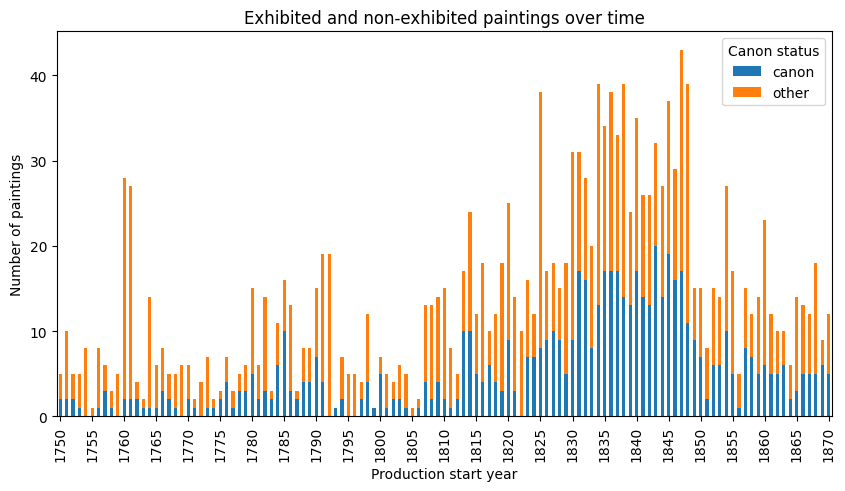

In [44]:
groupobject = df.groupby(['start_year', 'exb_canon']).size().unstack()
ax = groupobject.plot(kind='bar', stacked=True, figsize=(10, 5))

N = 5
ax.set_xticks(range(0, len(groupobject), N))
ax.set_xticklabels(groupobject.index[::5])

plt.title('Exhibited and non-exhibited paintings over time')
plt.xlabel('Production start year')
plt.ylabel('Number of paintings')
plt.legend(title='Canon status', loc='upper right')
plt.show()

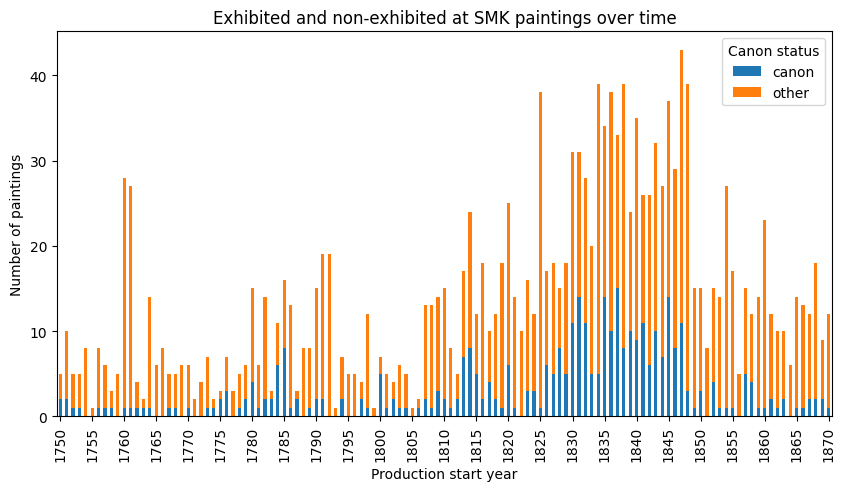

In [45]:
groupobject = df.groupby(['start_year', 'smk_exhibitions']).size().unstack()
ax = groupobject.plot(kind='bar', stacked=True, figsize=(10, 5))

N = 5
ax.set_xticks(range(0, len(groupobject), N))
ax.set_xticklabels(groupobject.index[::5])

plt.title('Exhibited and non-exhibited at SMK paintings over time')
plt.xlabel('Production start year')
plt.ylabel('Number of paintings')
plt.legend(title='Canon status', loc='upper right')
plt.show()

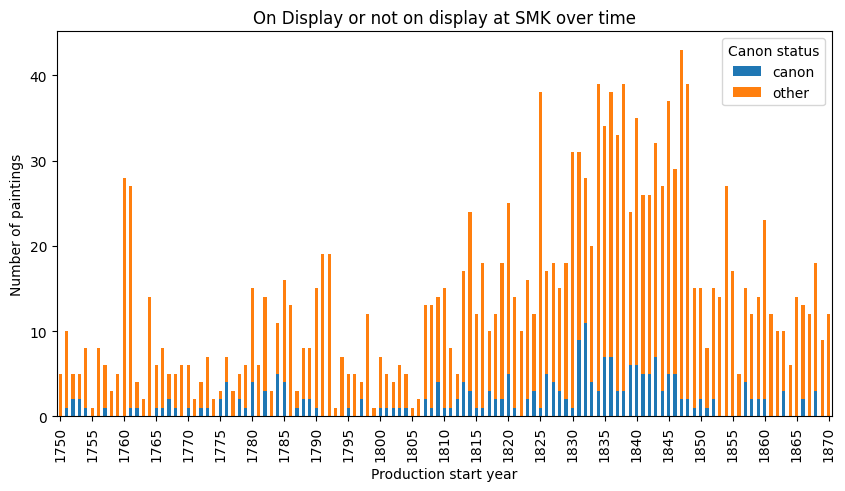

In [46]:
groupobject = df.groupby(['start_year', 'on_display']).size().unstack()
ax = groupobject.plot(kind='bar', stacked=True, figsize=(10, 5))

N = 5
ax.set_xticks(range(0, len(groupobject), N))
ax.set_xticklabels(groupobject.index[::5])

plt.title('On Display or not on display at SMK over time')
plt.xlabel('Production start year')
plt.ylabel('Number of paintings')
plt.legend(title='Canon status', loc='upper right')
plt.show()

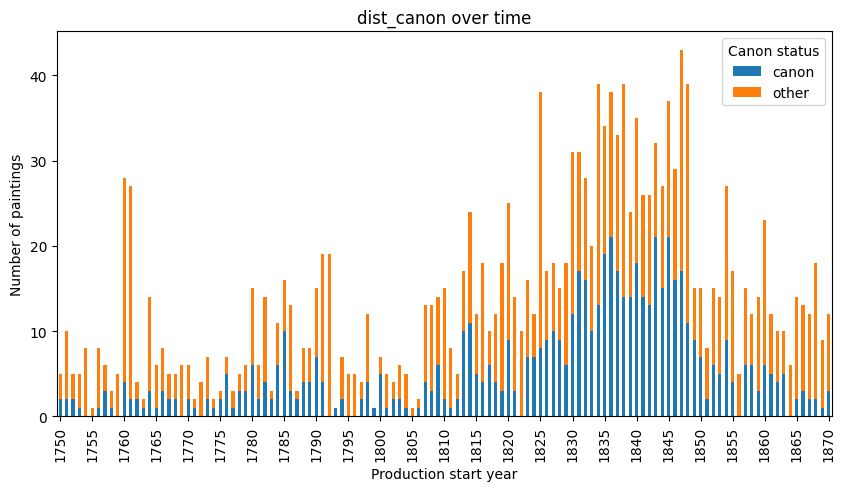

In [47]:
groupobject = df.groupby(['start_year', 'dist_canon']).size().unstack()
ax = groupobject.plot(kind='bar', stacked=True, figsize=(10, 5))

N = 5
ax.set_xticks(range(0, len(groupobject), N))
ax.set_xticklabels(groupobject.index[::5])

plt.title('dist_canon over time')
plt.xlabel('Production start year')
plt.ylabel('Number of paintings')
plt.legend(title='Canon status', loc='upper right')
plt.show()

In [48]:
# write new df with canon info to disk
data_path = os.path.join('..', 'data')
df.to_pickle(os.path.join(data_path, 'paintings_canonized.pkl'))